# Dislocation Dynamics

Simple 2D dislocation dynamics demonstration to relax a random dislocation configuration and then do a dynamic shear test. Numerically efficient use requires the use of the fortran library PK_force.

Author: Alexander Hartmaier</br>
Institute: ICAMS / Ruhr-universität Bochum</br>
Date: January 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>


## 1 Dislocations and stress fields

Provide functions to evaluate stress fields of edge dislocations according to

\begin{equation}
\sigma_{xx} = -\frac{\mu b_x}{2\pi (1-\nu)} \frac{y \left( 3x^2 + y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

\begin{equation}
\sigma_{yy} = \frac{\mu b_x}{2\pi (1-\nu)} \frac{y \left(x^2 - y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

\begin{equation}
\sigma_{xy} = \frac{\mu b_x}{2\pi (1-\nu)} \frac{x \left(x^2 - y^2 \right)}{\left(x^2 + y^2 \right)^2}
\end{equation}

Note that for the contributions of $b_y$ components of the Burgers verctors, $x$ and $y$ need to be exchanged in all above equations.


In [4]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pylabdd import Dislocations

#define functions for stress field evaluation
def sig_xx(X, Y):
    hx = np.multiply(X, X)
    hy = np.multiply(Y, Y)
    hh = hx + hy
    return -C*Y*(3.*hx + hy)/(hh*hh)

def sig_yy(X, Y):
    hx = np.multiply(X, X)
    hy = np.multiply(Y, Y)
    hh = hx + hy
    return C*Y*(hx - hy)/(hh*hh)

def sig_xy(X, Y):
    hx = np.multiply(X, X)
    hy = np.multiply(Y, Y)
    hh = hx + hy
    return C*X*(hx - hy)/(hh*hh)

## 2 Initialize dislocation configuration

Define material properties, simulation box and numerical parameters, total number of dislocation, number of mobile dislocations, number and inclination angle of slip planes.

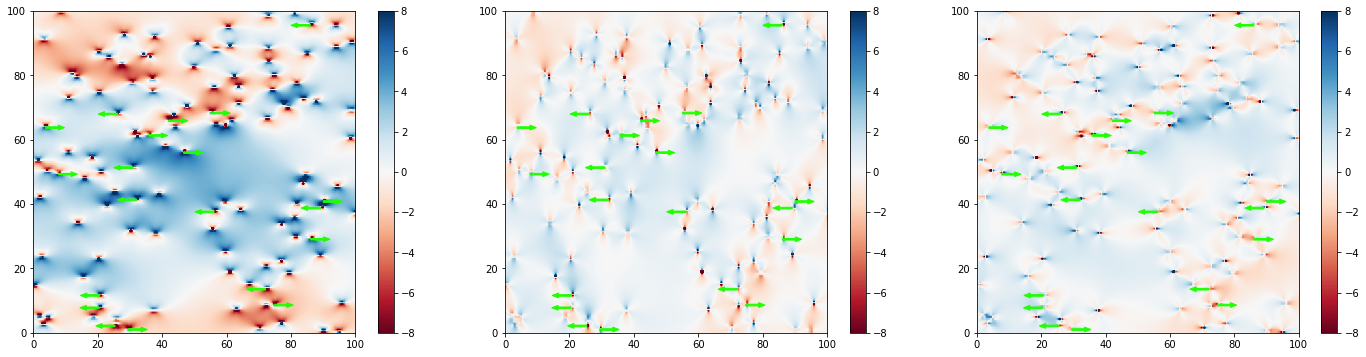

Initial configuration, Ntot: 120  Nmob:  20
box size: 100.0 micron x  100.0 micron
total dislocation density:  0.012 /micron^2
mobile dislocation density:  0.002 /micron^2


In [5]:
#define material parameters
#units: stress: MPa; length: micron; time: microseconds
mu = 80.0e3          # shear modulus
nu = 0.3             # Poisson ratio
b0 = 0.2e-3          # Burgers vector norm
C = mu*b0/(2*np.pi*(1.-nu))   # Constant for dislocation stress field
f0 = 10.             # initial slip resistance

#box geometry
LX = 100.             # box dimension in x-direction
LY = 100.             # box dimension in y-direction
bc = 'pbc'            # set boundary conditions: 'fixed' or 'pbc'

#define numerical parameters
dt0 = 0.02           # time step
np.random.seed(110)  # seed RNG

#define dislocations
Ntot = 120 # total number of dislocations
Nmob = 20  # number of mobile dislocations
dsl = Dislocations(Ntot, Nmob, 0., C, b0, LX=LX, LY=LY, bc=bc, f0=f0) 
dsl.positions()   # initialize positions randomly
dsl.plot_stress() # plot initial configuration
print('Initial configuration, Ntot:',dsl.Ntot,' Nmob: ',dsl.Nmob)
print('box size:',LX,'micron x ',LY,'micron')
print('total dislocation density: ',dsl.rho,'/micron^2')
print('mobile dislocation density: ',dsl.rho_m,'/micron^2')


## 3 Move dislocations to force equilibrium

Peach-Koehler force is defined as

\begin{equation}
F_{PK} = \left( \sigma \cdot b \right) \times l
\end{equation}

For 2D, plane stress conditions, $\sigma={\sigma_{11} \sigma_{12} \choose \sigma_{12} \sigma_{22} }$, $b= {b_x \choose b_y}$, and $l_x = l_y =0, l_z = 1$, such that

\begin{equation} 
F_{PK} = {\sigma_{12} b_x+\sigma_{22} b_y \choose \sigma_{11} b_x+\sigma_{12} b_y}. 
\end{equation}


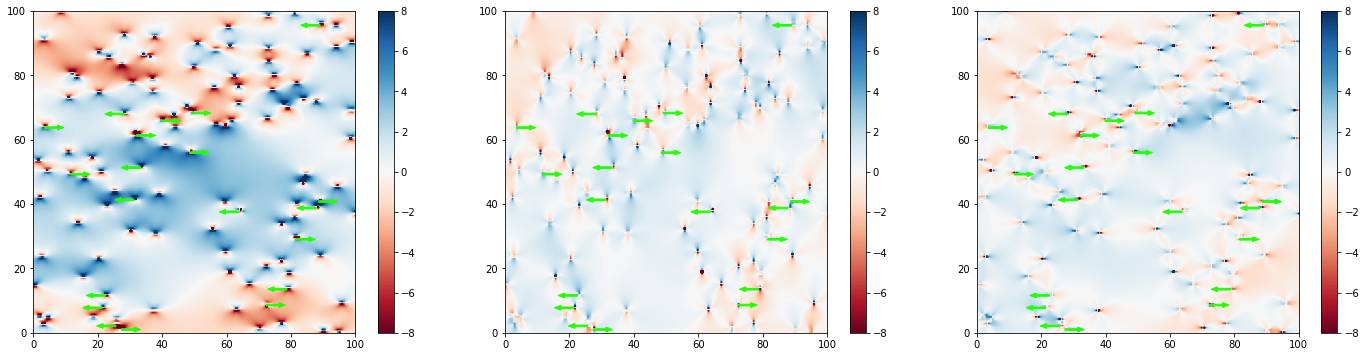

Iteration: 5000 , residual force: 0.14489702694768697


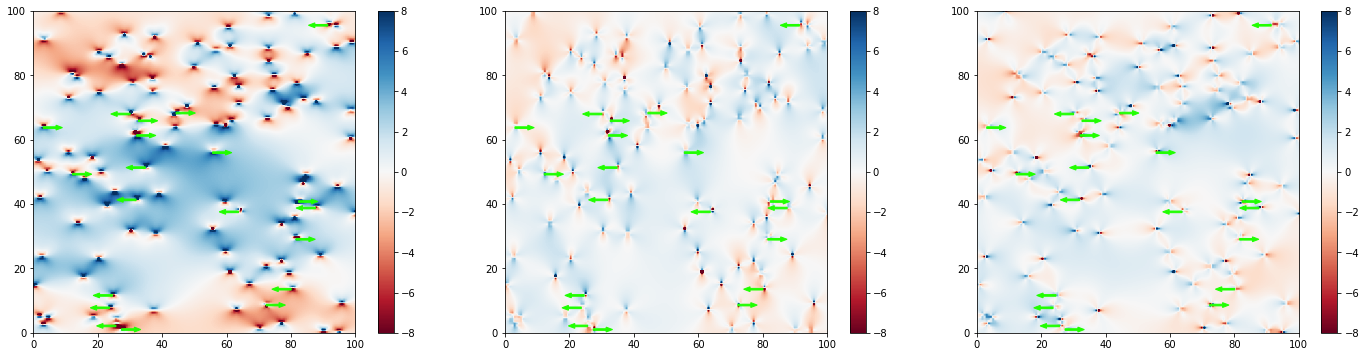

Iteration: 10000 , residual force: 0.0927153691005012


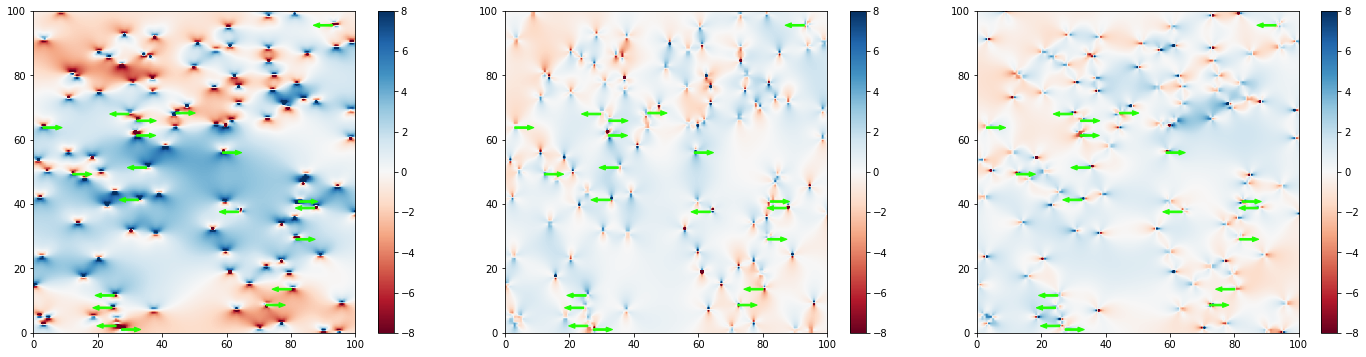

Final configuration 11606 0.049993183303652905


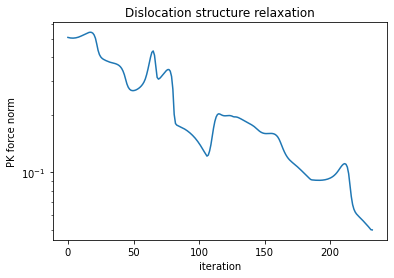

In [6]:
relax_all = False     # relax all dislocation if True, otherwise only mobile dislocations are relaxed
ftol = 5.e-2          # acceptable residual error in force relaxation

if relax_all:
    Nm = dsl.Ntot
else:
    Nm = dsl.Nmob
    
# initialze parameters for relaxation    
fn = 2.*ftol
nl = 0
nout = 1000
fout= int(50000/nout)
fd = []
dt = 0.03

while fn>ftol and nl<50000:
    fsp, dt = dsl.move_disl(0., Nm, 'viscous', dt)  # move dislocations w/o ext. stress, motion is viscous for relaxation
    fn = np.sum(np.absolute(fsp))/Nm
    nl += 1
    if np.mod(nl,fout)==0:
        ih = int(nl/fout)
        fd.append(fn)
    if np.mod(nl,5000)==0:
        dsl.plot_stress()
        print('Iteration:', nl, ', residual force:',fn)

fd.append(fn)
fd = np.array(fd)
dsl.plot_stress()
print('Final configuration', nl, fn)
xpeq = dsl.xpos   # store equilibrated configuration for multiple uses
ypeq = dsl.ypos
plt.semilogy(fd)
plt.title('Dislocation structure relaxation')
plt.xlabel('iteration')
plt.ylabel('PK force norm')
plt.show()

## 4.a Virtual shear testing (dynamic)

Virtual dynamic tensile test with loading rate  1.0 /s
Performing 100000 iterations with initial time step 0.005


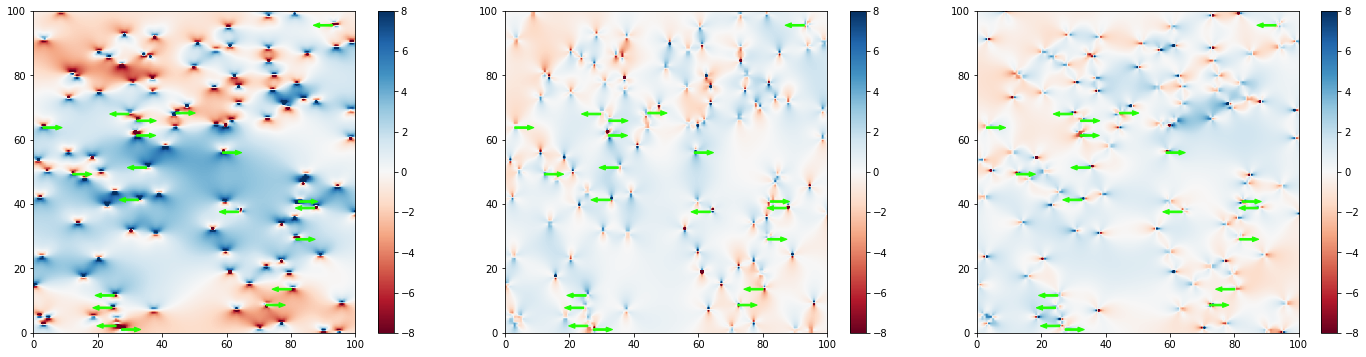

Start configuration:  120  dislocations, boxsize =  100.0 x 100.0 micron^2


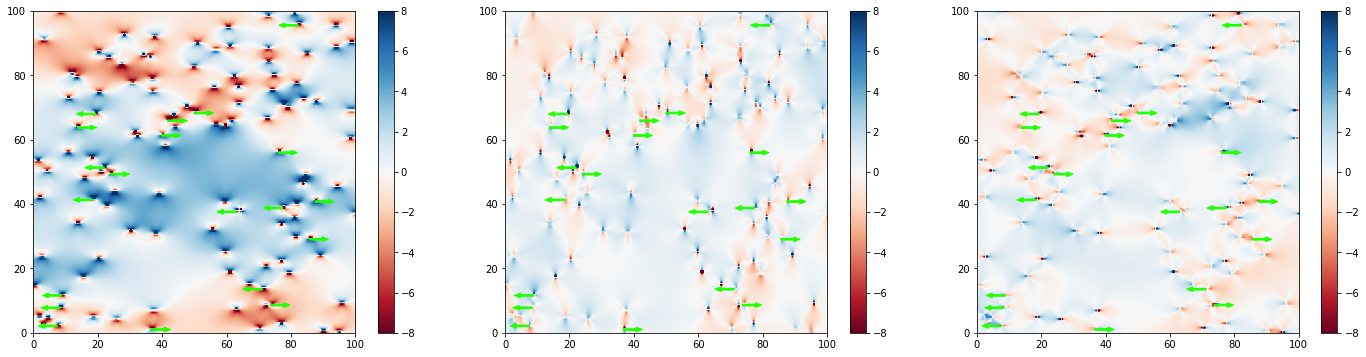

Configuration at sig =  4.385423597316608  epl =  8.047099279894405e-05  in iteration  10000 | Time step:  0.007


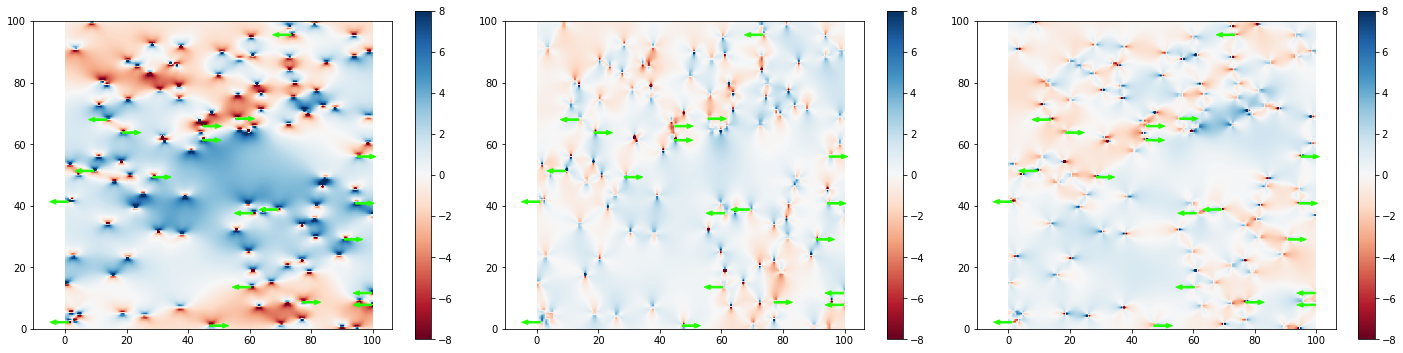

Configuration at sig =  4.264847536585249  epl =  0.00014360248285814957  in iteration  20000 | Time step:  0.00747


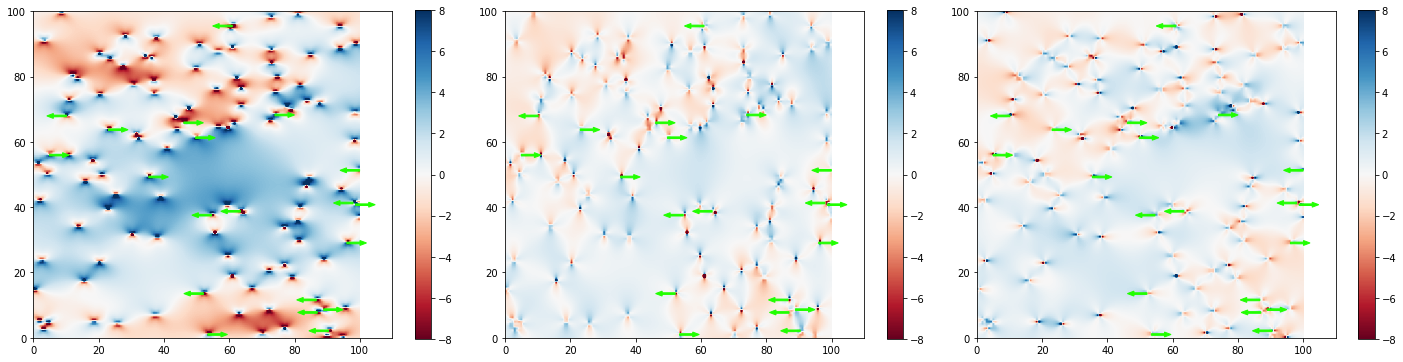

Configuration at sig =  4.135568813791986  epl =  0.00020715675401466695  in iteration  30000 | Time step:  0.00393


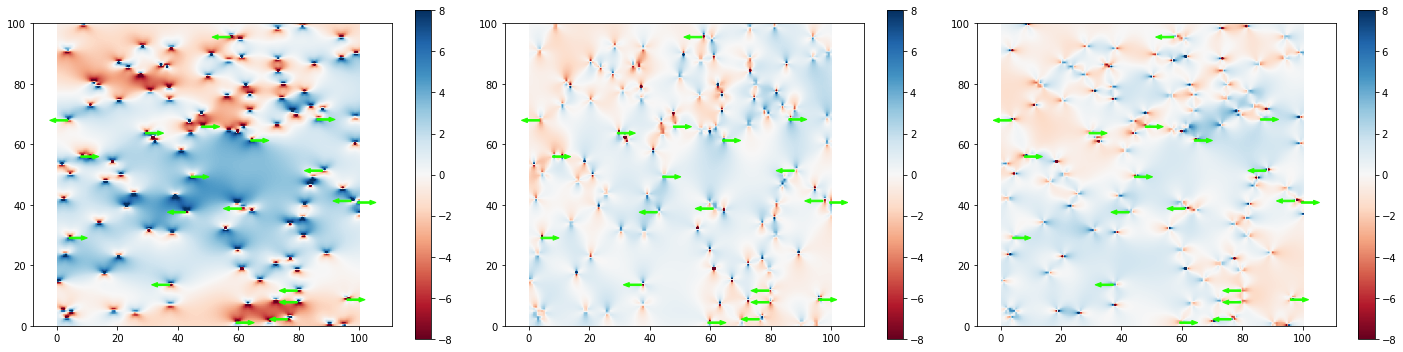

Configuration at sig =  4.272721417386402  epl =  0.000266794032881704  in iteration  40000 | Time step:  0.00567


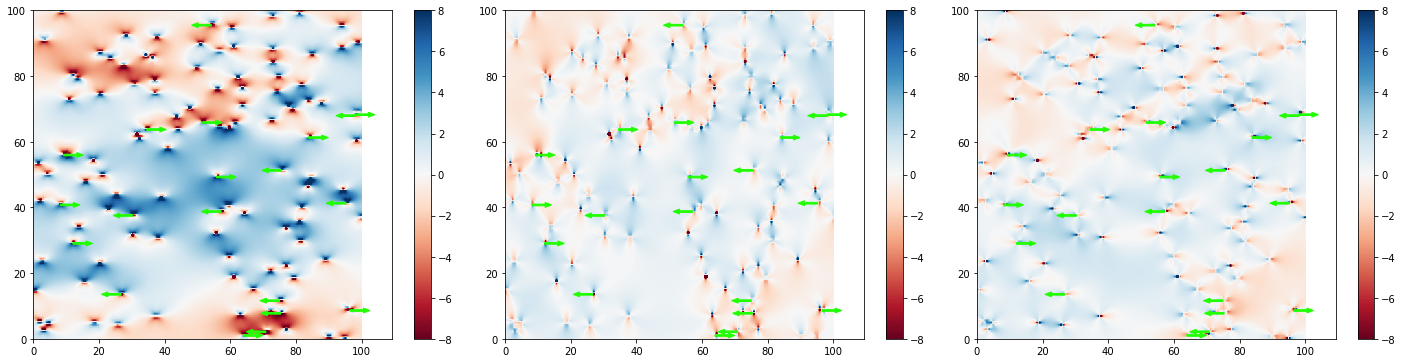

Configuration at sig =  4.362370679399826  epl =  0.000322344984109574  in iteration  50000 | Time step:  0.00567


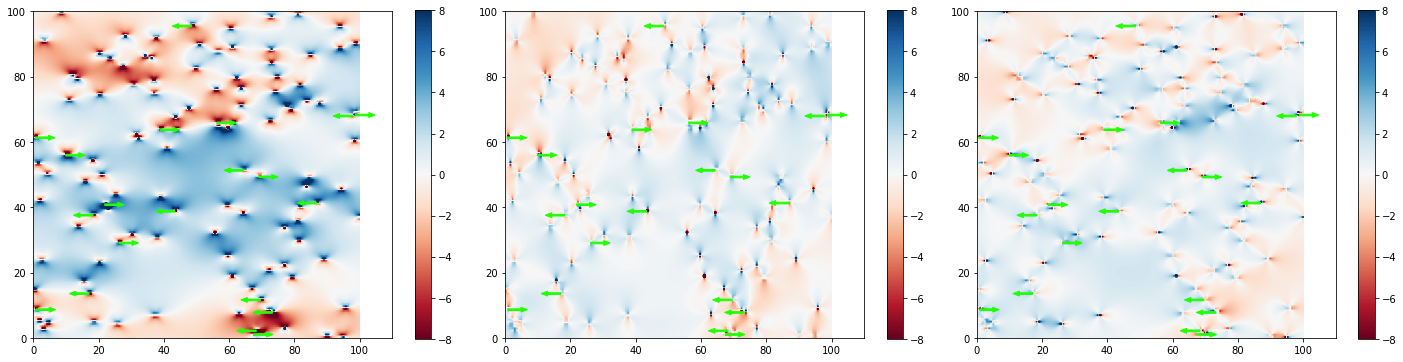

Configuration at sig =  4.420017995232038  epl =  0.0003812615748122749  in iteration  60000 | Time step:  0.0055
Number of iterations performed:  69669 | total strain achived:  0.0005000056452961495
Time step in last iteration:  0.007319069380940509


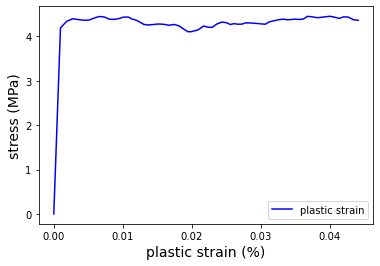

In [7]:
dsl.xpos = xpeq     # reset dislocation configuration for
dsl.ypos = ypeq     # multiple executions of this block
moblaw = 'powerlaw'   # set mobility law used for dislocation motion: 'viscous' or 'powerlaw'

#set strain parameters
edot = 1.e-6  # strain rate (per microsecond), vary between 1.e-8 and 1.e-5
efin = 0.0005   # final strain
nstep = 100000  # max number of steps (int(efin/(edot*dt*100.))*1000 )
idat = int(nstep/100) # frequency of data storage
ipl  = 10*idat # frequency of plotting
dt0 = 5.e-9/edot  #0.03    # values up to 0.05 yield similar results
dt = dt0

print('Virtual dynamic tensile test with loading rate ',edot*1e6,'/s')
print('Performing',nstep,'iterations with initial time step', dt0)
#initialize variables
tau0 = 0.     # macro shear stress
epl  = 0.     # plastic strain
etot = 0.     # total strain
sig_m = [0.]   # initialize list for stress values for postprocessing 
epl_m = [0.]
eps_m = [0.]
ic = 0
Nm = dsl.Nmob
Cpl = dsl.rho_m*b0  # prefactor for Orowan law

dsl.plot_stress()
print('Start configuration: ', dsl.Ntot, ' dislocations, boxsize = ',LX,'x',LY,'micron^2')

while etot<efin and ic<nstep:
    etot +=edot*dt
    tau0 = mu*(etot-epl)
    fsp, dt = dsl.move_disl(tau0, Nm, moblaw, dt)
    #calculate plastic slip
    dgpl = Cpl*(np.dot(dsl.dx,dsl.bx) + np.dot(dsl.dy,dsl.by))
    epl += dgpl
    if epl>etot:
        print('Warning: check time step', ic, nit, dgpl, tau0, epl, etot, fn)
    ic += 1
    if ic%idat==0:
        sig_m.append(tau0)
        eps_m.append(etot)
        epl_m.append(epl)
        if ic%ipl==0:
            dsl.plot_stress()
            print('Configuration at sig = ', tau0,' epl = ',epl,' in iteration ',ic,'| Time step: ',dt.round(5))

print('Number of iterations performed: ',ic,'| total strain achived: ',etot)
print('Time step in last iteration: ',dt)

epl_m = np.array(epl_m)
sig_m = np.array(sig_m)
eps_m = np.array(eps_m)
plt.plot(epl_m*100,sig_m,'b',label='plastic strain')
plt.xlabel('plastic strain (%)',fontsize=14)
plt.ylabel('stress (MPa)',fontsize=14)
plt.legend()
plt.show()

## 4.b Store stress-strain data for comparison

In [8]:
epl_r01 = epl_m
sig_r01 = sig_m
eps_r01 = eps_m
print('Total dislocation density:',dsl.rho,'/micron^2')
print('Total dislocation density:',dsl.rho_m,'/micron^2')

Total dislocation density: 0.012 /micron^2
Total dislocation density: 0.002 /micron^2


## 5 Plot results for several conditions

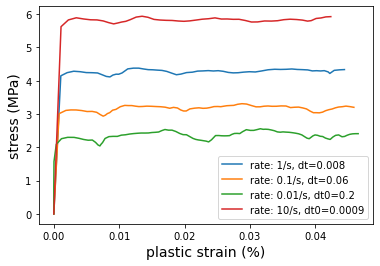

In [32]:
plt.plot(epl_e6*100,sig_e6,label='rate: 1/s, dt=0.008')
plt.plot(epl_e7*100,sig_e7,label='rate: 0.1/s, dt=0.06')
plt.plot(epl_e8*100,sig_e8,label='rate: 0.01/s, dt0=0.2')
plt.plot(epl_e5*100,sig_e5,label='rate: 10/s, dt0=0.0009')

plt.xlabel('plastic strain (%)',fontsize=14)
plt.ylabel('stress (MPa)',fontsize=14)
plt.legend()
plt.show()